In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold 
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
from itertools import permutations
from copy import deepcopy
from sklearn.metrics import accuracy_score
import bisect

In [2]:
workload_data = pd.read_csv(index_col=0, filepath_or_buffer='data.csv')
labeled_data = pd.read_csv(index_col=0, filepath_or_buffer='labels.csv')

In [3]:
# Quick look at what we're working with
#print(workload_data.head())
unique = np.unique(labeled_data)
# Check how many labels there are
print(len(unique))
labeled_data_items = labeled_data.values.flatten()

# Inserting the labels into a dict for easy access
label_indices = dict()
for item in unique:
    indices = [idx for idx, label in enumerate(labeled_data_items) if item == label]
    label_indices[item] = indices

5


Q1.1 Task 1:
- Are there missing values? Look on their website of the data to see how missing values are coded
Answer: It says on the website that the missing values are "N/A", but there aren't any (which can be seen in the code below)
- Compute the means and variances of the features (visualise in a histogram or with a kernel density estimate). Do they vary widely?
Answer: They do vary quite a lot yes, however they bot vary in mean quite normally, and for variance quite logarithmic.
- Are there constant features?
Answer: There are 267 columns with a variance of 0 (where they are full of 0s) and 14944 columns with a variance of less than 2.

In [4]:
contains_missing_values = workload_data.isna()
columns_with_missing_values = 0
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        columns_with_missing_values += 0
print(f'Amount of columns with missing values: {columns_with_missing_values}')
means = workload_data.mean()

variances = workload_data.var()
n_of_constant_values = variances[variances == 0]
n_of_low_var_values = variances[variances < 2]
print(f'Number of columns with variance = 0: {len(n_of_constant_values)} st')
print(f'Number of columns with variance < 2: {len(n_of_low_var_values)} st')
print(f'Amount of columns that are completely full of 0s: {sum([1 for x in means if x == 0])}')
print(f'There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset')

Amount of columns with missing values: 0
Number of columns with variance = 0: 267 st
Number of columns with variance < 2: 14944 st
Amount of columns that are completely full of 0s: 267
There are about 15000 columns below a variance of 2, so we will remove all columns below a variance of 2 later to get our refined dataset


In [5]:
for column_name in workload_data.columns: 
    if sum(contains_missing_values[column_name]) > 0:
        print(f'{column_name=}')
print(f'No missing values, all gene_values are numeric values')
means = workload_data.mean()
variances = workload_data.var()
variance_threshold = 2
n_of_constant_values = variances[variances < variance_threshold]
print(f'Number of columns with variance < 2: {len(n_of_constant_values)} st')
print(f'There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset')

No missing values, all gene_values are numeric values
Number of columns with variance < 2: 14944 st
There are about 15000 columns below a variance of 2, so we will reduce all columns below a variance of 2 later to get our refined dataset


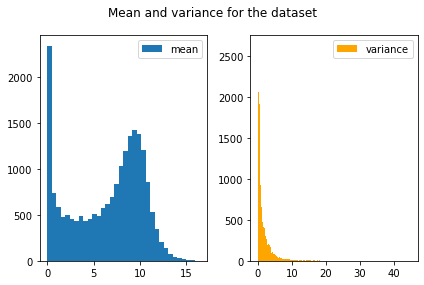

They do vary quite widely yes


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do vary quite widely yes')

Q1.1 Task 2:

In [7]:
trimmed_data = workload_data.copy()
data_columns = trimmed_data.columns
selector = VarianceThreshold(threshold=variance_threshold)

# rename them with same index and column names
columns_data = [f'gene_{i}' for i in range(1, 5580)]
rows_data = [f'sample_{i}' for i in range(1, 802)]
trimmed_data = pd.DataFrame(selector.fit_transform(trimmed_data), columns=columns_data, index=rows_data)

        

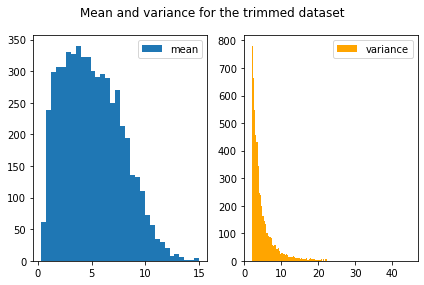

They do look alot better right now, gaussian and logarithmic


In [8]:
means = trimmed_data.mean()
variances = trimmed_data.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look alot better right now, gaussian and logarithmic')

-9.861168582277371e-17 4.705952576337255


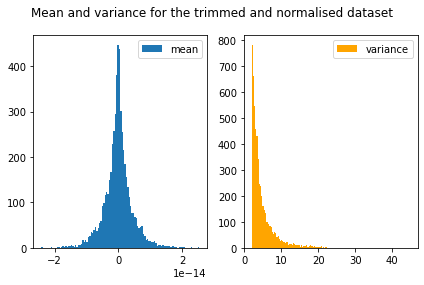

They do look very much "normalised", guess we will keep both and check


In [9]:
# Plot a normalised version to check if needed
normalized_df=(trimmed_data-trimmed_data.mean())
# Just checking it works
print(np.mean(np.mean(normalized_df)), np.mean(np.var(normalized_df)))

means = np.mean(normalized_df)
variances = np.var(normalized_df)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and normalised dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'They do look very much "normalised", guess we will keep both and check')


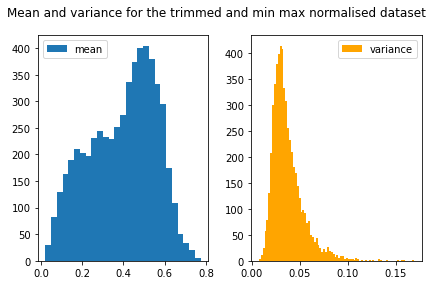

The min max version looks very similar to the original, might be an indication its not really needed


In [10]:
# Checking for max-min normalizing as well
min_max_df=(trimmed_data-trimmed_data.min())/(trimmed_data.max()-trimmed_data.min())

means = min_max_df.mean()
variances = min_max_df.var()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mean and variance for the trimmed and min max normalised dataset')
ax1.hist(means, bins='auto', label='mean')
ax2.hist(variances, bins='auto', label='variance', color='orange')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
print(f'The min max version looks very similar to the original, might be an indication its not really needed')

In [11]:
n_components = 10
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)
print(principalComponents.shape)

(801, 10)


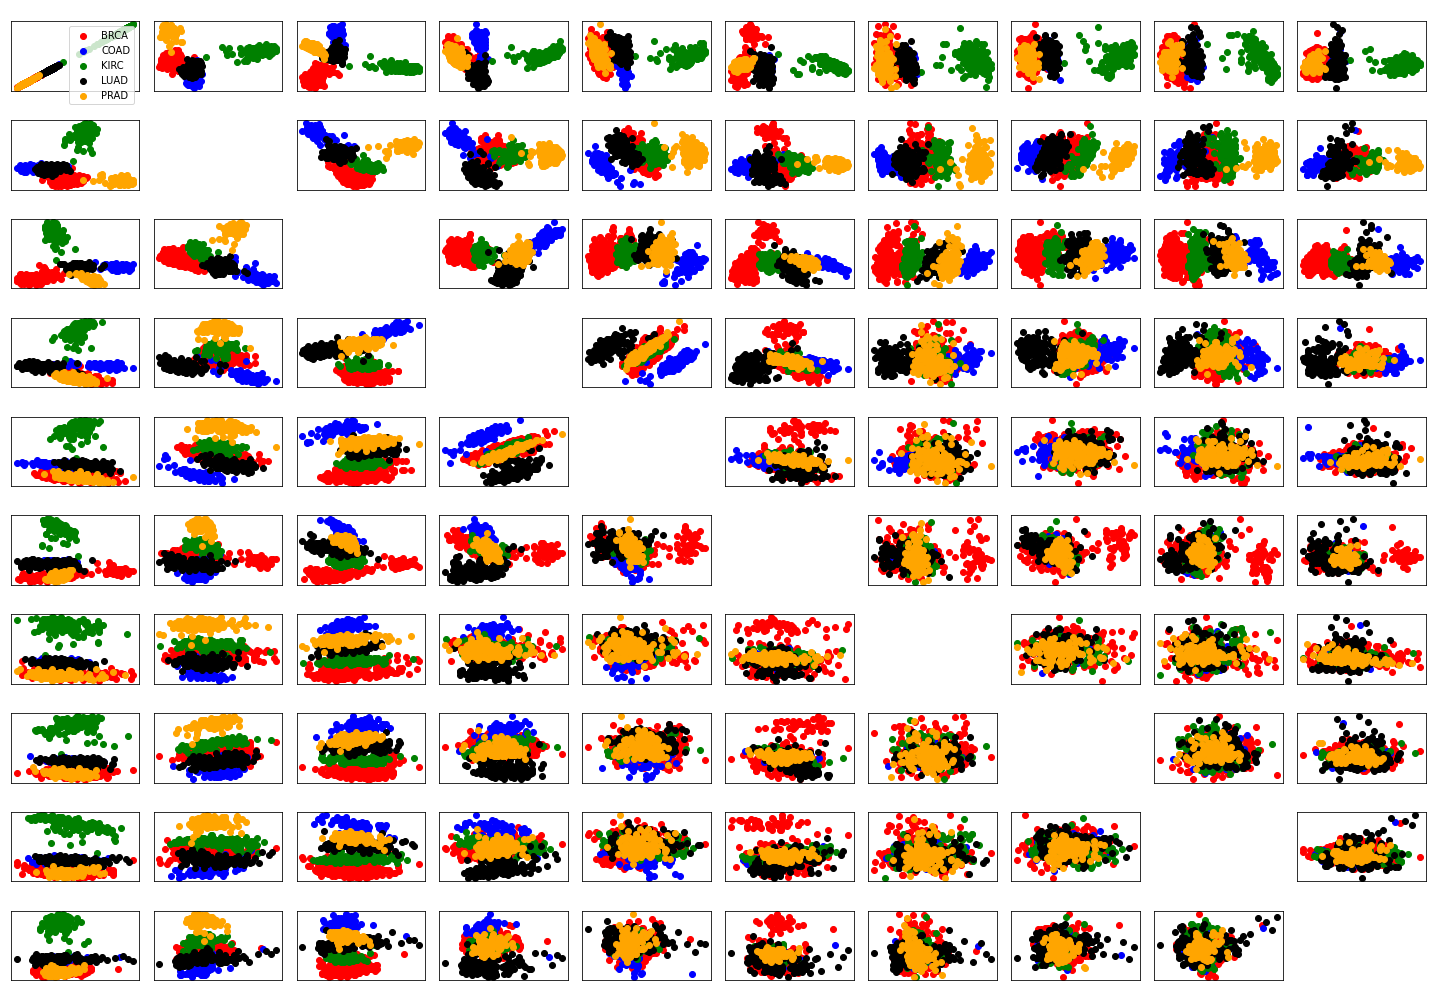

Here we can see that there are some clustered areas, up until about 5 there are some seperation, after that there is mostly just a blur


In [12]:

fig = plt.figure(figsize=(20,14))
plt.suptitle(f'{n_components} PCA analysis', color='White')
axes = fig.subplots(nrows=n_components, ncols=n_components)
colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'pink']

for x_index in range(n_components):
    for y_index in range(n_components):
        for (label, value), color in zip(label_indices.items(), colors):
            if (x_index == y_index) and (x_index != 0):
                axes[x_index, y_index].set_axis_off()
            elif (x_index == 0 and y_index == 0):
                axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color, label=label)
                axes[x_index, y_index].legend()
            else:
                axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color)
        axes[x_index, y_index].set_yticks(())
        axes[x_index, y_index].set_xticks(())
        #axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}', color='White') # <- Change the color before submission
        #axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}', color='White')

plt.tight_layout()
plt.show()
print('Here we can see that there are some clustered areas, up until about 5 there are some seperation, after that there is mostly just a blur')

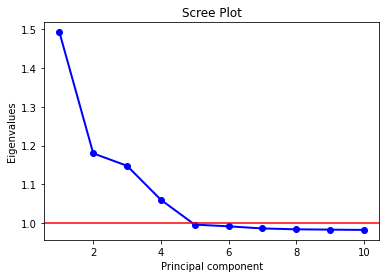

Not really sure what we're suppose to conclude here, HELP FREDRIK, guess there are 2 clear elbows at 2 and 5, 5 will probably be pretty good


In [13]:
# Doing the scree plot for 10 values 
n_components = 10
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)

PC_values = np.arange(pca.n_components) + 1
N = np.matrix(principalComponents.T)*np.matrix(principalComponents)

_, eigen_values, _ = np.linalg.svd(N)
#eigen_values = eigen_values[0:10]
eigen_values = eigen_values**2/np.sum(eigen_values**2)+0.98
plt.plot(PC_values, eigen_values, 'o-', linewidth=2, color='blue')
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()
print("Not really sure what we're suppose to conclude here, HELP FREDRIK, guess there are 2 clear elbows at 2 and 5, 5 will probably be pretty good")

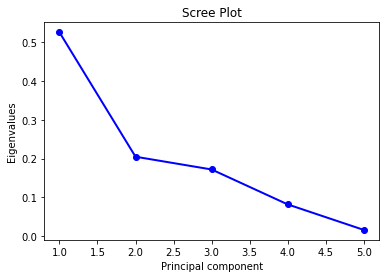

Not really right?


In [14]:
# Finally, check wather we can trim the PC-data further:
n_of_components = 5

pca = PCA(n_of_components)
principalComponents = pca.fit_transform(normalized_df)

PC_values = np.arange(pca.n_components) + 1
N = np.matrix(principalComponents.T)*np.matrix(principalComponents)
A, B, C = np.linalg.svd(N)
eigen_values = B**2/(np.sum(B**2))
plt.plot(PC_values, eigen_values, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal component')
plt.ylabel('Eigenvalues')
plt.show()

print('Not really right?')

Q1.2 Task 4

In [15]:
n_components = 6
pca = PCA(n_components)
principalComponents = pca.fit_transform(normalized_df)

n_of_clusters = 5
KM_model = KMeans(n_clusters=n_of_clusters, random_state=0)
KM_model.fit(principalComponents)
prediction = KM_model.predict(principalComponents).tolist()


# Mapping the predicted labels indices to the correct order list
label_perms = list(permutations(unique))
best_pred_score = 0
for label_list in label_perms:
    prediction_copy = deepcopy(prediction)
    for idx, label in enumerate(label_list):
        for jdx, item in enumerate(prediction_copy):
            if item == idx:
                prediction_copy[jdx] = label
    
    pred_score = accuracy_score(labeled_data_items, prediction_copy)
    if pred_score > best_pred_score:
        correct_label_list = label_list
        best_pred_score = pred_score
        best_prediction_copy = prediction_copy

print(best_pred_score, correct_label_list)

# Just making sure
print(np.sum(np.array(best_prediction_copy) == labeled_data.values.flatten())/len(labeled_data))

0.9950062421972534 ('PRAD', 'LUAD', 'KIRC', 'BRCA', 'COAD')
0.9950062421972534


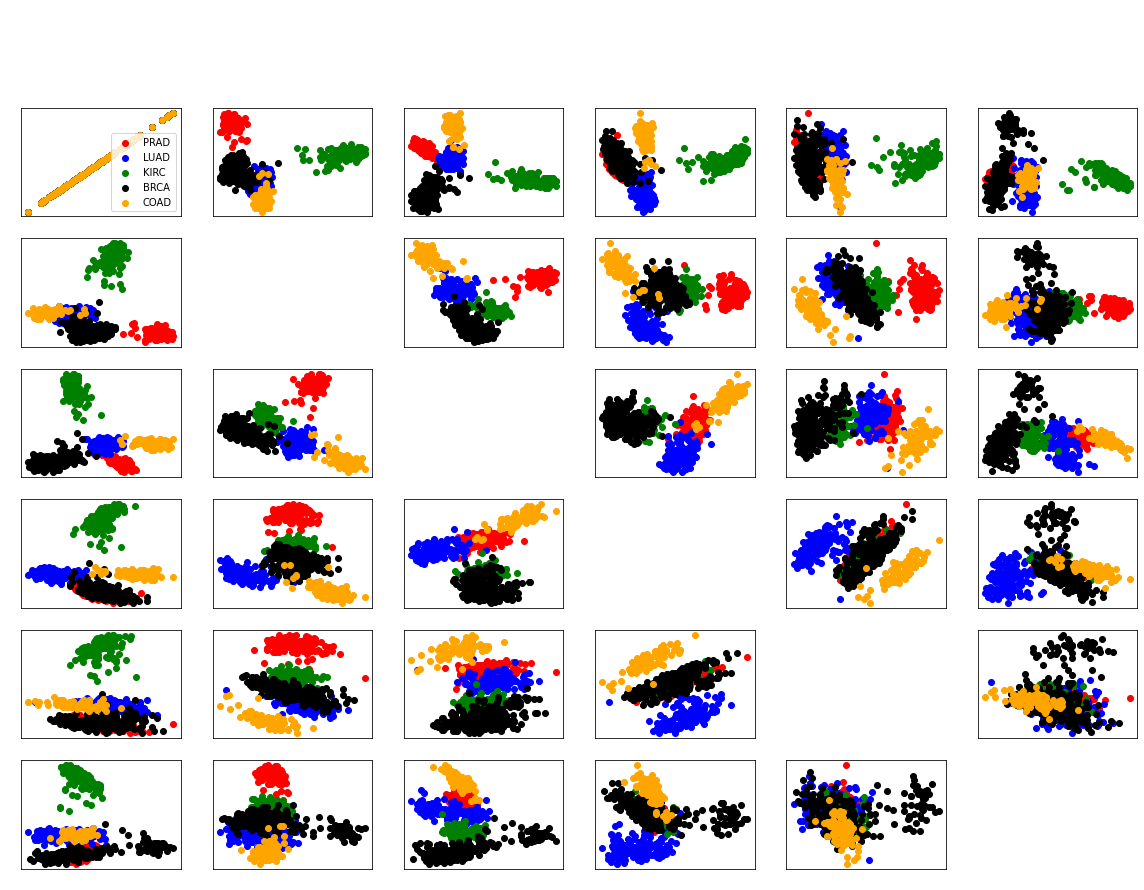

In [16]:


if n_components > 2:
    fig = plt.figure(figsize=(20,14))
    plt.suptitle(f'{n_components=} KM Clustering ', color='White')
    axes = fig.subplots(nrows=n_components, ncols=n_components)

    for x_index in range(n_components):
        for y_index in range(n_components):
            for cluster, color, label in zip(range(n_of_clusters), colors, correct_label_list):
                cluster_indices = [idx for idx, label in enumerate(prediction) if cluster == label]
                if x_index==y_index and x_index == 0 and n_of_clusters == 5:
                    axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color, label=label)
                    axes[x_index, y_index].legend()
                elif x_index == y_index:
                    axes[x_index, y_index].set_axis_off()


                else:
                    axes[x_index, y_index].scatter(principalComponents[cluster_indices, x_index], principalComponents[cluster_indices, y_index], color=color)
            axes[x_index, y_index].set_yticks(())
            axes[x_index, y_index].set_xticks(())
            axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}', color='White') # <- Change the color before submission
            axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}', color='White')
    plt.show()
else:
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
    y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = KM_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(principalComponents[:, 0], principalComponents[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = KM_model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering on the digits dataset (PCA-reduced data, dim 2)\n"
        "Centroids are marked with white cross", color='White' # <- Change this before turning in, otherwise this text wille be invisible (unless they run darkmode)
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [17]:
# fig = plt.figure(figsize=(16,12))
# plt.suptitle(f'{n_components=} KM Clustering ', color='White')
# axes = fig.subplots(nrows=n_components, ncols=n_components)



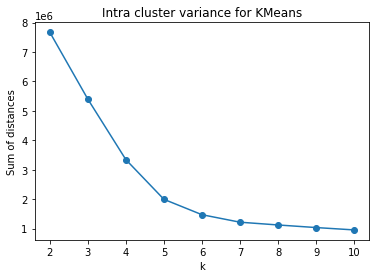

In [18]:
# Calculate the intra cluster variance for a range of cluster sizes and plot them (disclose which PCA size we use)
n_of_runs = 10
cluster_sizes = range(2, 11)
variance_sizes = np.zeros(len(cluster_sizes))
for _ in range(n_of_runs):
    for i, n_of_clusters in enumerate(cluster_sizes):
        n_of_clusters = cluster_sizes[i]
        KM_model = KMeans(n_clusters=n_of_clusters)
        KM_model.fit(principalComponents)
        variance_sizes[i] += KM_model.inertia_

variance_sizes /= n_of_runs

plt.plot(cluster_sizes, variance_sizes, 'o-')
plt.title('Intra cluster variance for KMeans')
plt.ylabel('Sum of distances')
plt.xlabel('k')
plt.show()

In [19]:
n_of_clusters = 5
GM_model = GaussianMixture(n_components=n_of_clusters, random_state=0)
GM_model.fit(principalComponents)
prediction = GM_model.predict(principalComponents).tolist()

# Mapping the predicted labels indices to the correct order list
label_perms = list(permutations(unique))
best_pred_score = 0
for label_list in label_perms:
    prediction_copy = deepcopy(prediction)
    for idx, label in enumerate(label_list):
        for jdx, item in enumerate(prediction_copy):
            if item == idx:
                prediction_copy[jdx] = label
    
    pred_score = accuracy_score(labeled_data_items, prediction_copy)
    if pred_score > best_pred_score:
        correct_label_list = label_list
        best_pred_score = pred_score
        best_prediction_copy = prediction_copy

print(best_pred_score, correct_label_list)

# Just making sure
print(np.sum(np.array(best_prediction_copy) == labeled_data.values.flatten())/len(labeled_data))

0.9987515605493134 ('PRAD', 'LUAD', 'KIRC', 'BRCA', 'COAD')
0.9987515605493134


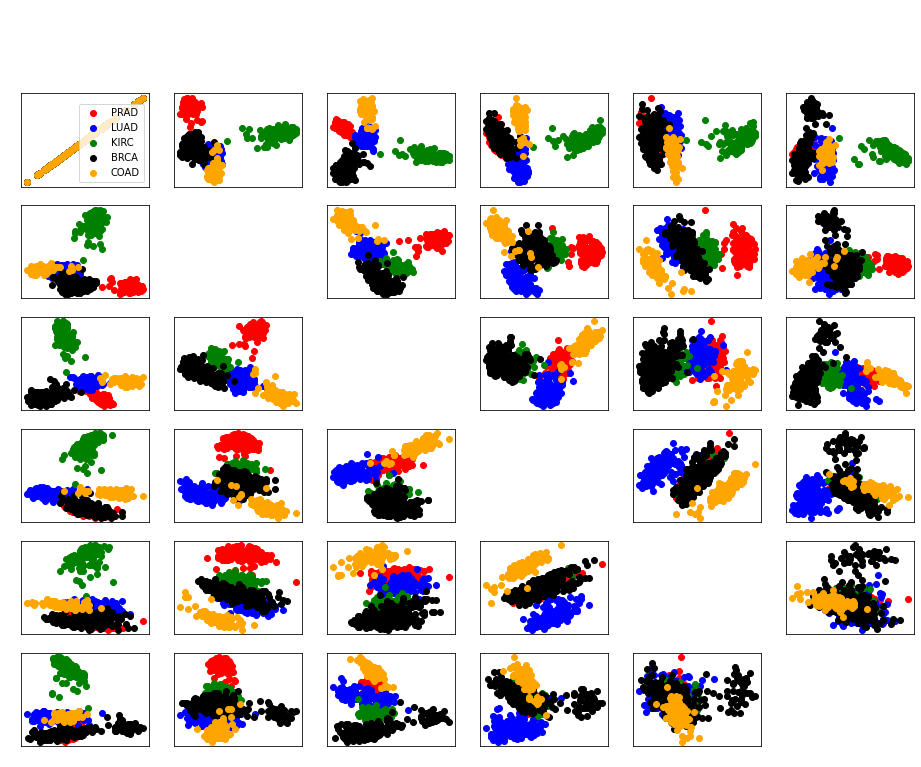

In [20]:
if n_components > 2:
    fig = plt.figure(figsize=(16,12))
    plt.suptitle(f'{n_components=} KM Clustering ', color='White')
    axes = fig.subplots(nrows=n_components, ncols=n_components)

    for x_index in range(n_components):
        for y_index in range(n_components):
            for cluster, color, label in zip(range(n_of_clusters), colors, correct_label_list):
                cluster_indices = [idx for idx, label in enumerate(prediction) if cluster == label]
                if x_index==y_index and x_index == 0:
                    axes[x_index, y_index].scatter(principalComponents[value, x_index], principalComponents[value, y_index], color=color, label=label)
                    axes[x_index, y_index].legend()
                elif x_index == y_index:
                    axes[x_index, y_index].set_axis_off()


                else:
                    axes[x_index, y_index].scatter(principalComponents[cluster_indices, x_index], principalComponents[cluster_indices, y_index], color=color)
            axes[x_index, y_index].set_yticks(())
            axes[x_index, y_index].set_xticks(())
            axes[x_index, y_index].set_xlabel(f'Principal component {x_index+1}', color='White') # <- Change the color before submission
            axes[x_index, y_index].set_ylabel(f'Principal component {y_index+1}', color='White')
    plt.show()
else:
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = principalComponents[:, 0].min() - 1, principalComponents[:, 0].max() + 1
    y_min, y_max = principalComponents[:, 1].min() - 1, principalComponents[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = GM_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(principalComponents[:, 0], principalComponents[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X

    plt.title(
        "GMM clustering on the digits dataset (PCA-reduced data, dim 2)\n"
        "Centroids are marked with white cross", color='White' # <- Change this before turning in, otherwise this text wille be invisible (unless they run darkmode)
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

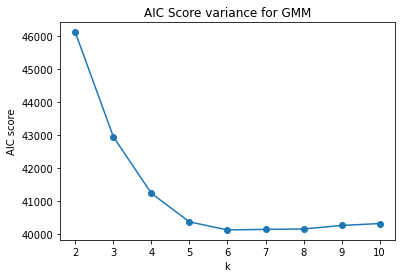

In [21]:
# Calculate the intra cluster variance for a range of cluster sizes and plot them (disclose which PCA size we use)

cluster_sizes = range(2, 11)
variance_sizes = np.zeros(len(cluster_sizes))
for _ in range(n_of_runs):
    for i, n_of_clusters in enumerate(cluster_sizes):
        n_of_clusters = cluster_sizes[i]
        GM_model = GaussianMixture(n_components=n_of_clusters)
        GM_model.fit(principalComponents)
        variance_sizes[i] += GM_model.bic(principalComponents)
        
variance_sizes /= n_of_runs


plt.plot(cluster_sizes, variance_sizes, 'o-')
plt.title('AIC Score variance for GMM')
plt.ylabel('AIC score')
plt.xlabel('k')
plt.show()

MIGHT ALSO BE THAT WE NEED DIFFERENT CLUSTER SIZE ANALYSIS TOOLS BUT THAT WOULD JUST BE TO USE SOME DIFFERENT ONES (SIluotte, squared distances (which I have) and one more for KMEANS), (BIC, AIC and one more for GMM)

Question 2. Task 5

Run number: 10 for K=2
Run number: 20 for K=2
Run number: 30 for K=2
0.29855003343199277 0.2985515920330548
-1.5586010620460833e-06


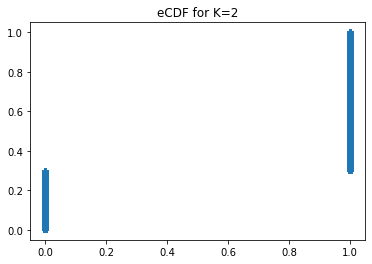

Run number: 10 for K=3
Run number: 20 for K=3
Run number: 30 for K=3
0.7221466300707138 0.3926505725521001
0.32949605751861366


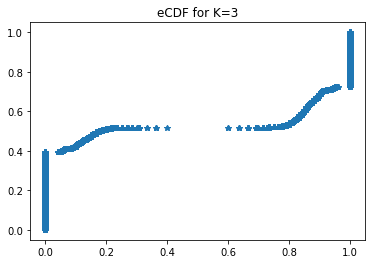

Run number: 10 for K=4
Run number: 20 for K=4
Run number: 30 for K=4
0.7251453785140609 0.7203152738228276
0.00483010469123335


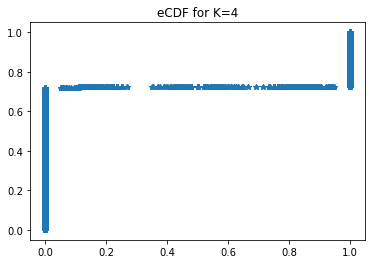

Run number: 10 for K=5
Run number: 20 for K=5
Run number: 30 for K=5
0.7559402182976648 0.7559417768987268
-1.5586010619905721e-06


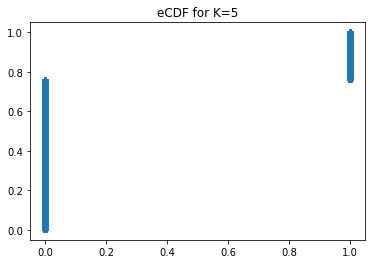

Run number: 10 for K=6
Run number: 20 for K=6
Run number: 30 for K=6
0.800843514894771 0.7989622834128999
0.0018812314818711373


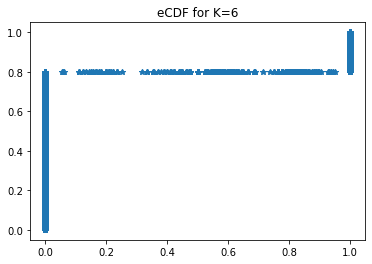

Run number: 10 for K=7
Run number: 20 for K=7
Run number: 30 for K=7
0.8547181192049265 0.8377433950383494
0.016974724166577082


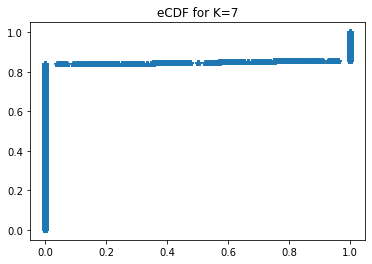

Run number: 10 for K=8
Run number: 20 for K=8
Run number: 30 for K=8
0.9035116840528615 0.8378992551445524
0.0656124289083091


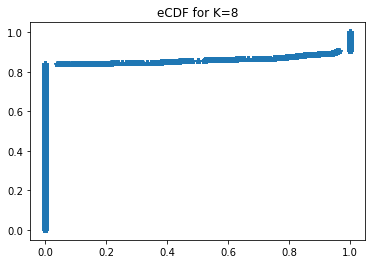

Run number: 10 for K=9
Run number: 20 for K=9
Run number: 30 for K=9
0.9233277379555206 0.8334416561071445
0.0898860818483761


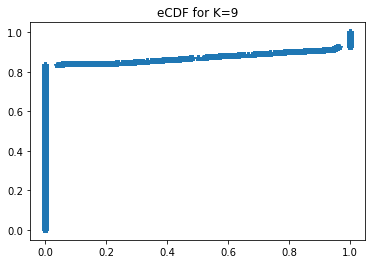

Run number: 10 for K=10
Run number: 20 for K=10
Run number: 30 for K=10
0.9368844499930642 0.8308637299505456
0.10602072004251861


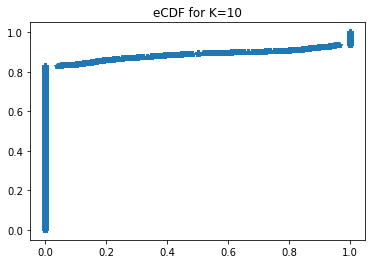

In [23]:
def BinarySearch(a, x):
    i = bisect.bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    else:
        return -1



dataset = principalComponents # Are we suppose to have principal components or just the normalized dataset here?
M = 10
Ks = range(2, M+1)
#Ks = [6]
n_of_samples = dataset.shape[0]
subset_size = int(0.8*n_of_samples)
n_of_runs = 30
q1 = 0.02
q2 = 1-q1
PACs = np.zeros(len(Ks))

for idx, n_of_clusters in enumerate(Ks):
    con_matrix = np.zeros((n_of_samples, n_of_samples))
    ind_matrix = deepcopy(con_matrix)

    for i in range(n_of_runs):
        chosen_indices = sorted(np.random.choice(range(1, n_of_samples), subset_size, replace=False))
        subset_dataset = dataset[chosen_indices]
        KM_model = KMeans(n_clusters=n_of_clusters)
        prediction = KM_model.fit_predict(subset_dataset)
        #indices_n_prediction = np.column_stack((chosen_indices, prediction))

        # Might be stupid to do this and instead loop double over the chosen indices (would take 36% less time I think (or maybe not since those times 
        # we just skip so might be unnecessary))
        for y_index in range(n_of_samples):
            y_sample = y_index + 1
            y_sample_pred_ind = BinarySearch(chosen_indices, y_sample)
            
            if y_sample_pred_ind != -1:
                for x_index in range(n_of_samples):  
                    x_sample = x_index + 1
                    x_sample_pred_ind = BinarySearch(chosen_indices, x_sample)
                    
                    if x_sample_pred_ind != -1:
                        
                        ind_matrix[y_index, x_index] += 1
                        x_sample_prediction = prediction[int(x_sample_pred_ind)]
                        y_sample_prediction = prediction[int(y_sample_pred_ind)]
                        if x_sample_prediction == y_sample_prediction:
                            con_matrix[y_index, x_index] += 1
                            
        if (i + 1) % 10 == 0:
            print(f'Run number: {i+1} for K={n_of_clusters}')     

    C = np.zeros((n_of_samples, n_of_samples))
    for i in range(n_of_samples):
        for j in range(n_of_samples):
            if (con_matrix[i, j] > 0) and (ind_matrix[i,j] > 0):
                C[i, j] = con_matrix[i, j]/ind_matrix[i, j]
    
    # Calculate the first index that is bigger that q2 and the last index that is smaller than q1 

    C = C.flatten()
    x = np.array(sorted(C, reverse=False))
    y = np.arange(len(x))/float(len(x))
    f_q2 = y[np.where(x < q2)[0][-1]]
    f_q1 = y[np.where(x > q1)[0][0]]
    print(f_q2, f_q1)
    
    PAC = (f_q2 - f_q1)
    print(PAC)
    PACs[idx] = PAC
    plt.plot(x, y, '*')
    plt.title(f'eCDF for K={n_of_clusters}')
    plt.show()






[-1.55860106e-06  3.29496058e-01  4.83010469e-03 -1.55860106e-06
  1.88123148e-03  1.69747242e-02  6.56124289e-02  8.98860818e-02
  1.06020720e-01]


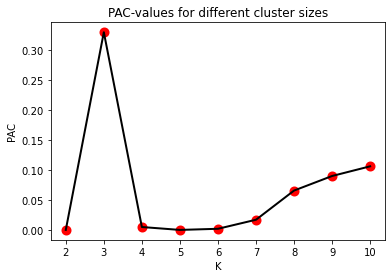

In [27]:
plt.plot(Ks, PACs, color='black', linewidth=2)
plt.scatter(Ks, PACs, color='red', linewidths=4)
plt.title('PAC-values for different cluster sizes')
plt.xlabel('K')
plt.ylabel('PAC')
print(PACs)

THEME - DBSCAN

There are so many clustering methods to choose from. Select one from the book or other sources. Make sure you understand the underlying assumptions of the method, apply it to this data and compare to your previous findings.

DBSCAN: Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density. 

An abstract description of the algorithm:
1. Find the points in the $ \epsilon $ neighborhood of every point, and identify the core points with more than minPts neighbors.

2. Find the connected components of core points on the neighborhood graph, ignoring all non-core points. 

3. Assign each non-core point to a nearby cluster if the cluster is an $ \epsilon $ nieghbor, otherwise assign it to noise. 

A naive implementation of this requires storing the neighborhoods in step 1, thus requiring substantial memory. The original DBSCAN algorithm does not require this by performing these steps for one point at a time.

Advantages:

1. Does not require a certain cluster size, it determines that on it's own with the other parameters you give it.

2. DBSCAN can find clusters with arbitrarily shapes. Can for example find cluster surrounded by other cluster as long as the paramters are correctly given.

3. Has mechanism for noise and is therefor robust to outliers.

4. Requires only two parameters. 

Disadvantages:

1. The model is not entirely deterministic. 

2. The method depends heavily on the distance function chosen and is therefor rendered almost useless for high dimensionality due to the curse of dimensionality, but that is true for many other clustering algorithms as well.

3. Can't cluster data sets well with large differences in density. 

4. If the data and scale are not well understood, choosing a meaningful distance threshold $ \epsilon $ might be difficult.

Assumptions about DBSCAN:

One of the advantages of DBSCAN is that it identifies irregularly shaped clusters. 



In [78]:
n_components = 5
pca = PCA(n_components)
dataset = pca.fit_transform(normalized_df)

76.42512695338102


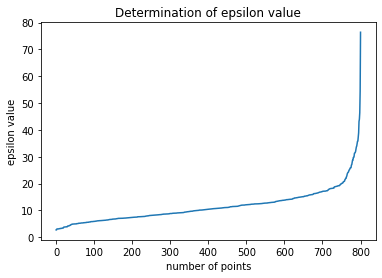

In [111]:
# Determine the value of epsilon
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(dataset)

distances, indicies = nbrs.kneighbors(dataset)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
print(max(distances))
plt.plot(distances)
#plt.hlines(y=20, xmin=0, xmax=len(distances), color='red')
plt.xlabel('number of points')
plt.ylabel('epsilon value')
plt.title('Determination of epsilon value')
plt.show()


Estimated number of clusters: 6
Estimated number of noise points: 113
Silhouette Coefficient: 0.461


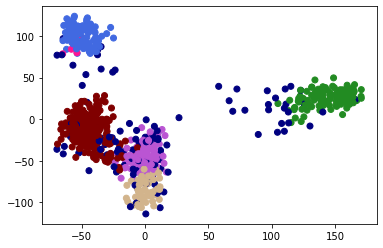

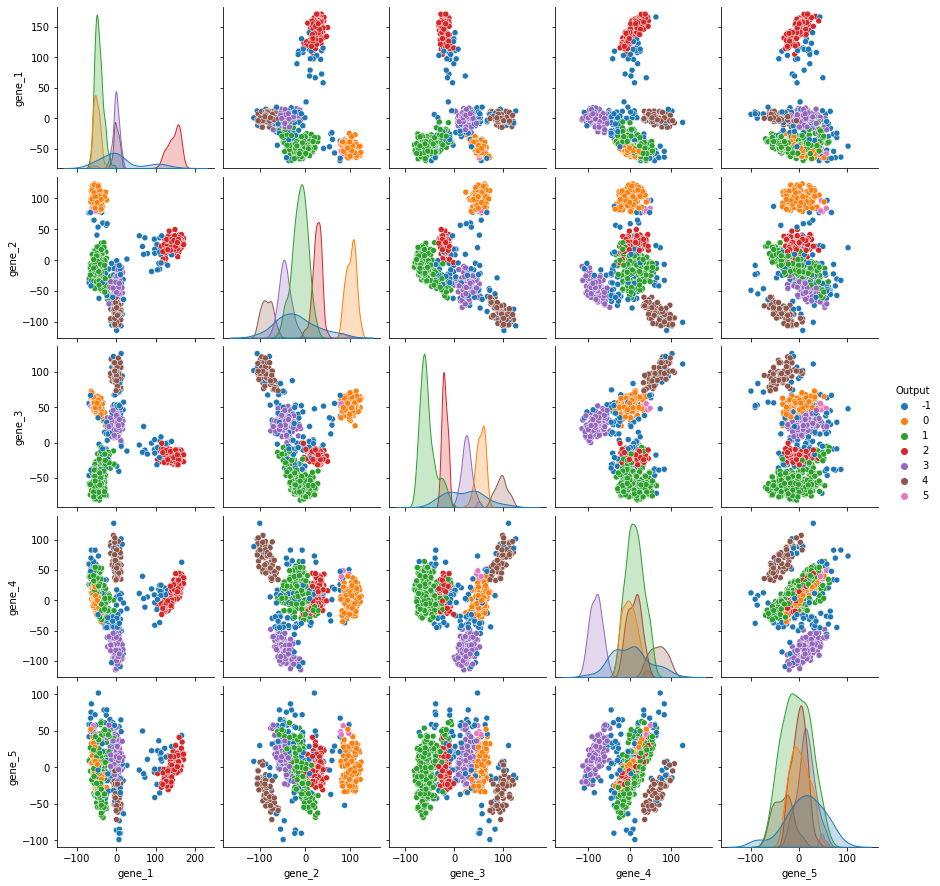

In [113]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
 


db = DBSCAN(eps=20).fit(dataset)
colors = ['royalblue', 'maroon', 'forestgreen', 
'mediumorchid', 'tan', 'deeppink', 
'olive', 'goldenrod', 'lightcyan', 'navy']
clusters = db.labels_
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.scatter(dataset[:,0], dataset[:,1], c=vectorizer(clusters))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
columns_data = [f'gene_{i}' for i in range(1, n_of_components+1)]
rows_data = [f'sample_{i}' for i in range(1, 802)]
df = pd.DataFrame(dataset, columns=columns_data, index=rows_data)
df['Output'] = labels
sns.pairplot(df, hue='Output', palette='tab10')


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(dataset, labels))

# # Black removed and is used for noise instead.
# unique_labels = set(labels)
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k

#     xy = dataset[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14, 
#         zorder=2
#     )

#     xy = dataset[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#         zorder=1
#     )
# #colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]


# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()


